In [1]:
# Import the necessary libraries and load the data with required columns
import pandas as pd
import numpy as np
import re
import nltk # type: ignore
from nltk.corpus import stopwords # type: ignore
import textblob # type: ignore
from textblob import TextBlob # type: ignore
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import random
import imblearn # type: ignore
from imblearn.over_sampling import SMOTE # type: ignore
file_path = "Sentiment_Analysis_Dataset.xlsx" # Enter required file path
data = pd.read_excel(file_path)
new_data = data.drop('reviewerName', axis = 1)
data_sentiment_analysis = new_data.drop(new_data.columns[5:], axis = 1)

In [2]:
# Preprocess the text by removing punctuations, extra whitespaces, contractions (for example, do not -> don't)
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"n't", "not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = " ".join([word for word in text.split() if word not in stopwords.words("english")])
    return text

data_sentiment_analysis['cleanedText'] = data_sentiment_analysis['reviewText'].apply(preprocess_text)

sentiment_class
positive    4449
negative     324
neutral      142
Name: count, dtype: int64


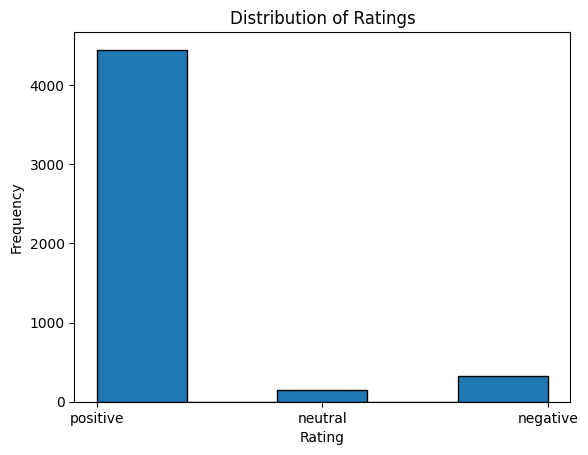

In [3]:
# Method 1 : Sentiment Analysis with TextBlob
# In Sentiment Analysis with TextBlob, we define a function to classify and analyze the sentiment based on ratings from 1 to 5.
# Then, we impute the missing values in the 'overall' column with the mean of existing values and convert to numeric data type accounting for NaN values.
# Then, we analyze the distribution of the sentiment.
# Finally, we try to visualize the distribution of ratings.

def categorize_sentiment(overall):
    overall = int(overall)
    if overall >= 4:
        return 'positive'
    elif overall <= 2:
        return 'negative'
    else:
        return 'neutral'

data_sentiment_analysis['overall'] = data_sentiment_analysis['overall'].fillna(data_sentiment_analysis['overall'].mean())
data_sentiment_analysis['overall'] = pd.to_numeric(data_sentiment_analysis['overall'], errors = 'coerce')
data_sentiment_analysis['sentiment_class'] = data_sentiment_analysis['overall'].apply(categorize_sentiment)
data_sentiment_analysis = data_sentiment_analysis.sort_values(by = 'overall', ascending = False)
sentiment_counts = data_sentiment_analysis['sentiment_class'].value_counts()
print(sentiment_counts)
plt.hist(data_sentiment_analysis['sentiment_class'], bins = 5, edgecolor = 'black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

In [4]:
# Method 2 : Using Machine Learning Models
# In the Naive Bayes Machine Learning Model Method, we first perform feature extraction to convert text into numeric form.
# Then, we split the data with 80% as training data and 20% as testing data.
# Then, we create a Naive Bayes model, and perform cross-validation on k folds (for example, k = 5 for quicker computation time.)
# We also create models with Support Vector Machine (SVM) and Random Forest Classifier algorithms.
# Then, we perform hyperparameter tuning on the three models, and create a dictionary with the best models with the three algorithms.
# Finally, we evaluate the model, and obtain accuracy, precision, recall, and F1-score for the trained model.
# In addition, we will also create and visualize a confusion matrix.
# Note : If there is a possible significant imbalance in the classes, we can use the SMOTE function in the imbalanced-learn library.
# Note: SMOTE (Synthetic Minority Over-Sampling Technique) is used to generate synthetic samples for minority classes, which improves the overall performance of the model.

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data_sentiment_analysis['cleanedText'])
y = data_sentiment_analysis['sentiment_class']
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state)

param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv = 5)
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_ 

param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}
# random_state = 42 ensures metrics are fixed for reproducibility. It can be omitted to get truly random, replicable results for metrics in the next code block.
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid_rf, cv = 5)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

param_grid_nb = {'alpha': [0.1, 1.0, 10.0]}
grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv = 5)
grid_search_nb.fit(X_train, y_train)
best_nb = grid_search_nb.best_estimator_

Model: SVC
Accuracy: 0.7294
Precision: 0.3272
Recall: 0.3248
F1-Score: 0.3209
              precision    recall  f1-score   support

    negative       0.07      0.14      0.09        71
     neutral       0.02      0.03      0.03        32
    positive       0.89      0.80      0.84       880

    accuracy                           0.73       983
   macro avg       0.33      0.32      0.32       983
weighted avg       0.80      0.73      0.76       983


Confusion Matrix for SVC(C=0.1, kernel='linear'):



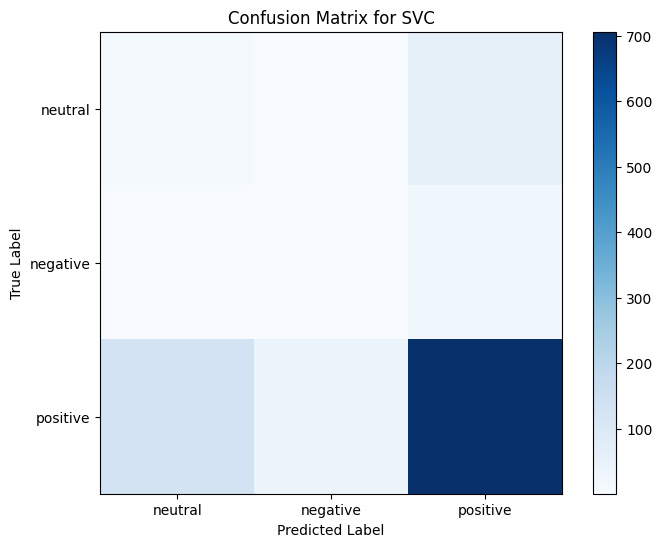

Model: RandomForestClassifier
Accuracy: 0.7854
Precision: 0.3505
Recall: 0.3456
F1-Score: 0.3428
              precision    recall  f1-score   support

    negative       0.08      0.14      0.10        71
     neutral       0.07      0.03      0.04        32
    positive       0.90      0.86      0.88       880

    accuracy                           0.79       983
   macro avg       0.35      0.35      0.34       983
weighted avg       0.81      0.79      0.80       983


Confusion Matrix for RandomForestClassifier(max_depth=5, random_state=42):



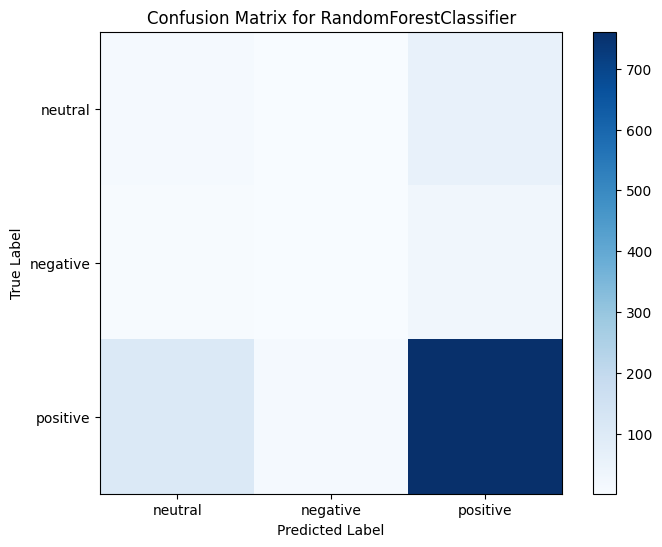

Model: MultinomialNB
Accuracy: 0.6429
Precision: 0.3401
Recall: 0.3529
F1-Score: 0.3228
              precision    recall  f1-score   support

    negative       0.09      0.24      0.13        71
     neutral       0.04      0.12      0.06        32
    positive       0.89      0.69      0.78       880

    accuracy                           0.64       983
   macro avg       0.34      0.35      0.32       983
weighted avg       0.81      0.64      0.71       983


Confusion Matrix for MultinomialNB():



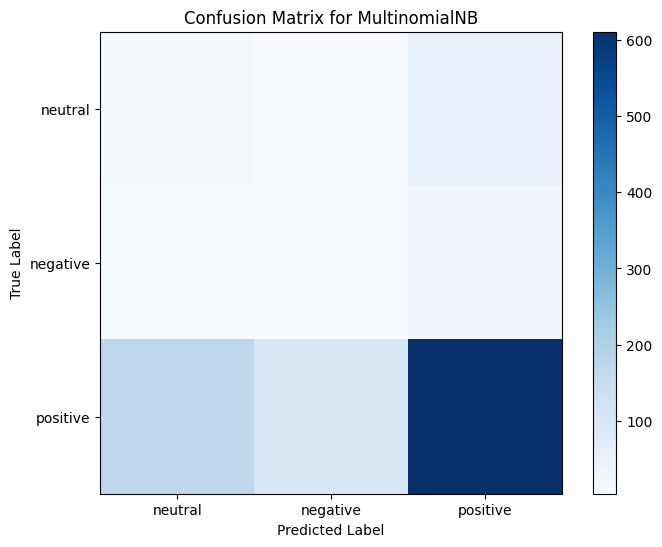

In [5]:
# Model comparison
models = [best_svm, best_rf, best_nb]
model_name = ["SVM", "Random Forest", "Naive Bayes"]
sm = SMOTE(random_state = 42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
for model in models:
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    print(f"Model: {type(model).__name__}")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), ndigits = 4))
    print("Precision:", round(precision_score(y_test, y_pred, average = 'macro', zero_division = 0), ndigits = 4))
    print("Recall:", round(recall_score(y_test, y_pred, average = 'macro', zero_division = 0), ndigits = 4))
    print("F1-Score:", round(f1_score(y_test, y_pred, average = 'macro', zero_division = 0), ndigits = 4))
    print(classification_report(y_test, y_pred)) 
    print()
    print(f"Confusion Matrix for {model}:\n")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (8, 6))
    plt.imshow(cm, cmap = 'Blues', interpolation = 'nearest')
    plt.title(f'Confusion Matrix for {type(model).__name__}')
    plt.colorbar()
    tick_marks = np.arange(len(set(y)))
    plt.xticks(tick_marks, set(y))
    plt.yticks(tick_marks, set(y))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()